In [212]:
import keras 
import numpy as np
from keras.preprocessing.text import Tokenizer
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Flatten, GlobalAveragePooling1D, LSTM, Reshape
from keras.models import Model, Sequential
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [213]:
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [214]:
train_data = pd.read_csv('text_emotion.csv')

In [215]:
train_data.head()

,sentiment,content
0,joy,[ On days when I feel close to my partner and ...
1,fear,Every time I imagine that someone I love or I ...
2,anger_disgust,When I had been obviously unjustly treated and...
3,sadness,When I think about the short time that we live...
4,anger_disgust,At a gathering I found myself involuntarily si...


In [216]:
train_data['target'] = train_data.sentiment.astype('category').cat.codes

In [217]:
train_data['num_words'] = train_data.content.apply(lambda x : len(x.split()) if type(x) == str else 0)

In [218]:
bins=[0,50,75, np.inf]
train_data['bins']=pd.cut(train_data.num_words, bins=[0,100,300,500,800, np.inf], labels=['0-100', '100-300', '300-500','500-800' ,'>800'])

In [219]:
word_distribution = train_data.groupby('bins').size().reset_index().rename(columns={0:'counts'})

In [220]:
word_distribution.head()

,bins,counts
0,0-100,7630
1,100-300,22
2,300-500,0
3,500-800,0
4,>800,0


Text(0.5, 1.0, 'Word distribution per bin')

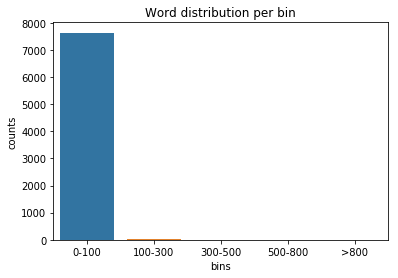

In [221]:
sns.barplot(x='bins', y='counts', data=word_distribution).set_title("Word distribution per bin")

In [222]:
num_class = len(np.unique(train_data.sentiment.values))
y = train_data['target'].values
num_class

5

In [223]:
MAX_LENGTH = 300
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.content.values)
post_seq = tokenizer.texts_to_sequences(train_data.content.values)
post_seq_padded = pad_sequences(post_seq, maxlen=MAX_LENGTH)

In [224]:
X_train, X_test, y_train, y_test = train_test_split(post_seq_padded, y, test_size=0.05)
y_train

array([3, 1, 1, ..., 2, 2, 1], dtype=int8)

In [225]:
vocab_size = len(tokenizer.word_index) + 1

In [237]:
inputs = Input(shape=(MAX_LENGTH, ))
embedding_layer = Embedding(vocab_size,
                            128,
                            input_length=MAX_LENGTH)(inputs)

# x = Flatten()(embedding_layer)
x = LSTM(32, input_shape=(32, 32))(embedding_layer)
x = Dense(32, activation='relu')(x)

predictions = Dense(num_class, activation='softmax')(x)
model = Model(inputs=[inputs], outputs=predictions)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

model.summary()
filepath="weights-simple.hdf5"
checkpointer = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history = model.fit([X_train], batch_size=128, y=to_categorical(y_train), verbose=1, validation_split=0.05, 
          shuffle=True, epochs=10, callbacks=[checkpointer])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 300)               0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 300, 128)          1171712   
_________________________________________________________________
lstm_9 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dense_17 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_18 (Dense)             (None, 5)                 165       
Total params: 1,193,541
Trainable params: 1,193,541
Non-trainable params: 0
_________________________________________________________________
Train on 6905 samples, validate on 364 samples
Epoch 1/10
6905/6905 [==============================] - 27s 4ms/step - loss: 1.5411 -

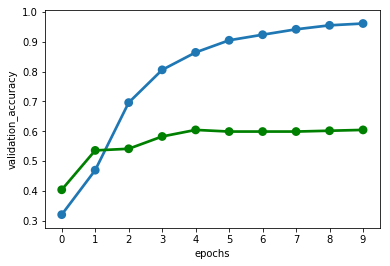

In [238]:
df = pd.DataFrame({'epochs':history.epoch, 'accuracy': history.history['acc'], 'validation_accuracy': history.history['val_acc']})
g = sns.pointplot(x="epochs", y="accuracy", data=df, fit_reg=False)
g = sns.pointplot(x="epochs", y="validation_accuracy", data=df, fit_reg=False, color='green')

In [239]:
predicted = model.predict(X_test)
predicted = np.argmax(predicted, axis=1)
accuracy_score(y_test, predicted)

0.597911227154047

In [240]:
y_test

array([3, 4, 4, 2, 4, 2, 4, 1, 1, 1, 3, 4, 4, 0, 2, 3, 1, 0, 4, 0, 4, 4,
       3, 0, 1, 3, 3, 0, 0, 1, 1, 0, 0, 0, 4, 4, 4, 3, 0, 3, 3, 4, 4, 0,
       4, 3, 1, 2, 2, 4, 4, 4, 0, 4, 3, 3, 4, 2, 0, 1, 4, 1, 3, 0, 0, 2,
       4, 3, 0, 0, 1, 4, 1, 1, 1, 0, 4, 0, 0, 0, 3, 4, 4, 0, 0, 2, 1, 0,
       0, 3, 3, 2, 4, 3, 4, 0, 0, 1, 1, 4, 2, 3, 4, 4, 0, 4, 1, 2, 0, 4,
       0, 3, 0, 0, 3, 3, 4, 1, 0, 3, 3, 0, 1, 4, 4, 2, 4, 2, 2, 2, 4, 4,
       2, 0, 4, 0, 4, 4, 2, 4, 4, 2, 0, 0, 4, 0, 4, 1, 1, 1, 0, 2, 0, 0,
       4, 1, 4, 0, 0, 2, 1, 1, 3, 3, 0, 0, 2, 1, 0, 1, 2, 3, 4, 4, 4, 4,
       2, 4, 4, 4, 0, 0, 1, 3, 0, 4, 0, 4, 4, 2, 3, 3, 4, 4, 4, 2, 2, 4,
       1, 3, 1, 0, 2, 4, 0, 0, 0, 4, 3, 3, 0, 4, 3, 4, 3, 0, 0, 2, 2, 0,
       4, 0, 3, 0, 4, 2, 4, 1, 4, 4, 2, 0, 4, 0, 2, 0, 3, 2, 3, 0, 4, 1,
       3, 3, 3, 0, 0, 4, 2, 0, 2, 4, 0, 2, 2, 1, 3, 3, 4, 4, 0, 1, 0, 4,
       4, 3, 0, 0, 4, 0, 4, 1, 1, 2, 2, 1, 4, 4, 2, 0, 4, 0, 4, 1, 0, 2,
       4, 4, 0, 0, 0, 2, 0, 0, 0, 0, 3, 4, 0, 2, 1,

In [241]:
predicted

array([3, 4, 4, 0, 0, 2, 2, 4, 1, 2, 4, 4, 4, 4, 0, 3, 2, 0, 4, 4, 4, 0,
       2, 0, 2, 3, 3, 4, 4, 1, 0, 4, 3, 0, 4, 4, 4, 0, 4, 4, 3, 4, 4, 0,
       3, 3, 1, 4, 2, 0, 4, 4, 4, 0, 3, 3, 3, 4, 2, 0, 4, 0, 1, 4, 0, 2,
       4, 3, 0, 0, 2, 4, 1, 4, 1, 4, 1, 4, 3, 0, 2, 4, 4, 0, 4, 2, 1, 0,
       4, 4, 3, 0, 4, 4, 4, 0, 4, 1, 1, 4, 2, 1, 4, 3, 0, 0, 3, 2, 0, 0,
       0, 3, 0, 0, 3, 3, 3, 0, 0, 3, 3, 0, 0, 4, 4, 4, 4, 2, 2, 0, 0, 4,
       4, 0, 4, 0, 2, 4, 2, 4, 4, 2, 0, 4, 4, 0, 3, 0, 1, 4, 2, 2, 4, 0,
       4, 4, 4, 4, 4, 2, 1, 1, 3, 0, 0, 4, 2, 1, 0, 1, 2, 3, 1, 4, 4, 4,
       2, 4, 4, 4, 0, 4, 0, 4, 4, 4, 0, 0, 0, 2, 3, 3, 4, 4, 3, 2, 2, 3,
       1, 0, 4, 4, 0, 4, 0, 0, 3, 0, 3, 0, 0, 0, 3, 0, 4, 1, 0, 2, 0, 1,
       4, 4, 3, 4, 0, 2, 2, 1, 4, 4, 2, 0, 0, 0, 3, 1, 4, 2, 0, 0, 4, 4,
       3, 3, 4, 0, 0, 0, 2, 0, 2, 4, 1, 2, 2, 1, 4, 4, 4, 3, 2, 4, 0, 4,
       4, 3, 3, 0, 4, 0, 3, 1, 0, 2, 2, 0, 4, 3, 2, 0, 2, 0, 4, 1, 4, 2,
       4, 4, 0, 3, 4, 0, 0, 4, 4, 0, 2, 4, 0, 2, 1,

In [242]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [243]:
cnf_matrix = confusion_matrix(y_test, predicted)
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[62  6  4  5 30]
 [10 29  4  1 10]
 [ 8  0 38  1  4]
 [ 6  2  4 32 14]
 [22  4  6 13 68]]


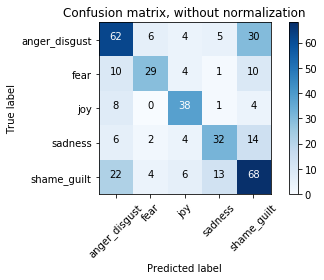

In [244]:
class_names = ['anger_disgust', 'fear', 'joy','sadness', 'shame_guilt']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

Normalized confusion matrix
[[0.58 0.06 0.04 0.05 0.28]
 [0.19 0.54 0.07 0.02 0.19]
 [0.16 0.   0.75 0.02 0.08]
 [0.1  0.03 0.07 0.55 0.24]
 [0.19 0.04 0.05 0.12 0.6 ]]


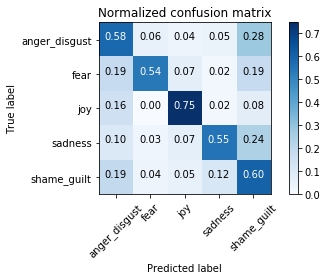

In [245]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

In [252]:
tweets = [
  "Watching the sopranos again from start to finish!",
  "Finding out i have to go to the  dentist tomorrow",
  "Sun in my eyes but I don't mind, what a beautiful day we've had in New York today!",
  "Feels like someone's stabbed me in my hope",
  "Do people have no Respect for themselves or you know others peoples homes",
  "I want to go outside and chalk but I have no chalk",
  "I hate coming to the doctors when I feel as if I might have a big problem",
  "My mom wasn't mad",
  "You don't indicate once I'm already in the road THEN rev and honk at me you stupid bitch #learnhowtodrive #bitch",
  "Come home from work and this is on my doorstep. I guess he has a secret admirer",
  "The 'egyption hot models' facebook page is pathetic... simply photos of obese horny women.",
  "I HATE PAPERS AH #AH #HATE",
]

post = """West Bengal chief minister and Trinamool Congress (TMC) chief Mamata Banerjee's efforts to rename the state as 'Bangla' have again faced an obstacle from the Ministry of Home Affairs (MHA).

According to The Indian Express, the home ministry has expressed concern over this move, saying that the name "may sound like Bangladesh and that it would be difficult to differentiate the two at international forums". The home ministry has written to the Ministry of External Affairs, the report said, to obtain an opinion before any further consideration.

However, in 2016, Mamata had addressed the possibility of the name being confused with Bangladesh. Noting that the name 'Bangla' had historical significance, she had said, "In English it will be Bengal, so that there will be no confusion with the name of neighbouring Bangladesh."

File image of West Bengal chief minister Mamata Banerjee. PTIFile image of West Bengal chief minister Mamata Banerjee. PTI
A constitutional amendment is required for a change in the name of a state. A recent example of the name of a state being changed was that of Odisha (earlier called Orissa).

Banerjee's plans to rename the state have been taking shape since 2011, when the newly elected chief minister had put forward 'Paschim Banga' as an option.

Banerjee's effort in 2011 never saw the light of day at the Centre, and was unsuccessful even in 2016 when the state Assembly passed a resolution to change the name of West Bengal to language-specific names. The cabinet had proposed that the name of the state be 'Bengal' in English, 'Bangla' in Bengali, and 'Bangal' in Hindi. Then, the home ministry had rejected the proposal saying that it would not be possible for a state to have different names in different languages.

However, in July this year, the West Bengal Assembly unanimously passed a resolution to change the state's name to 'Bangla'.

According to reports, the state's Assembly pushed more strongly for the renaming after the July 2016 Inter-State Council meeting in Delhi, when Banerjee was the last chief minister to address the Council because the speakers were listed in alphabetical order of the states. The name 'Bangla' would bump the state up in an alphabetically-organised list to number four.

Apart from political repercussions of the move to rename the state, with the Left, Congress, and BJP state parties walking out of the Assembly in August 2016 over the issue, political analysts have warned against reigniting tensions in the Darjeeling and Kalimpong areas of the state. People residing in "the hills" as the areas are colloquially referred to, had in 2017 initiated a strong resistance to the state government's move to make Bengali a mandatory language in schools in the state.

The Gorkha and Nepali communities of the state demanded a separate state "Gorkhaland" in protest and as an assertion of the linguistic differences in the state. Even though those protests were successfully pacified by the Mamata Banerjee-government after three months, experts believe that there continues to be a divide in socio-cultural aspects in the state.

As this report by Marcus Dam points out, the attempt to rename the state may not go down well in the hills, as "Bangla" is also the locally accepted term for the Bengali language."""

list = post.split(".")

post_seq = tokenizer.texts_to_sequences(list)
post_seq_padded = pad_sequences(post_seq, maxlen=MAX_LENGTH)
p = model.predict(post_seq_padded)
p = np.argmax(p, axis=1)
final = [0, 0, 0, 0, 0]
for i in p:
    final[i] += 1

p

[41, 6, 14, 15, 28]